<a href="https://colab.research.google.com/github/Plogeur/HAI923/blob/main/Notebook_Preprocessing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> Notebook Preprocessing 2 : Dataset, kfold et data augmentation </H1>

La preprocessing est une étape cruciale en deep learning qui impacte considérablement le succès d'un modèle de réseau neuronal. Les modèles en réseaux neuronaux convolutionnels (CNN)  sont fortement axés sur les données et nécessitent que les données d'entrée soient dans un format approprié pour un apprentissage efficace et une généralisation adéquate. Le prétraitement implique une série de transformations de données et d'opérations de nettoyage appliquées aux données brutes en vue de les rendre plus adaptées à l'entraînement des réseaux neuronaux profonds.

Les techniques de prétraitement courantes comprennent :

- La visualisation du jeux de données (voir notebook visualisation)

- La normalisation des données, pour mettre à l'échelle les caractéristiques d'entrée dans une plage commune (généralement entre [0,1] mais il arrive parfois que des modèle soit entrainer sur [-1,1] donc il faudra adapter le preprocessing en conséquence).

- Le redimensionnement et les ajustements des canaux.

- L'augmentation des données pour accroître la diversité de l'ensemble d'entraînement

- La gestion des données manquantes ou bruitées.

*Note à moi-même : Il faut bien commencée quelque part, j'imagine...*

# Installation

In [ ]:
import time
import numpy as np
import os
import seaborn as sns
import random
import shutil
import keras
import pandas as pd
from numpy import mean
from numpy import std
import cv2
from PIL import Image
import matplotlib.cm as cm
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras import metrics
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.saving import load_model
from sklearn.model_selection import KFold
from scipy import stats
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Flatten, Rescaling, Conv2D, BatchNormalization, MaxPooling2D
import matplotlib.pyplot as plt
import pathlib
import sys

In [ ]:
# GLOBAL VARIABLE
IMG_SIZE = 128
BATCH_SIZE = 4
CHANEL = 3
N_KFOLDS = 10
STOPPING_PATIENCE = 100 # Arret de l'apprentissage après X epochs
REDUCTION_PATIENCE = 25 # Diminution de la valeur de l'apprentissage après X epochs
EPOCHS = 100
VERBOSE = 1
COLUMNS = 25
SEED = 123
NUMBERCLASS = 3
POLICE_SIZE = 18 # Taille de la police pour les plot
plt.rcParams.update({'font.size': POLICE_SIZE})
PATH_DIR = "/content/gdrive/MyDrive/Colab Notebooks/HAI923/Tiger-Fox-Elephant/"

# SET SEED
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# CALLBACKS
EARLY_STOPPING = \
        EarlyStopping(
            monitor='val_loss',
            patience=STOPPING_PATIENCE,
            verbose=VERBOSE,
            mode='auto')

LR_REDUCTION = \
        ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=REDUCTION_PATIENCE,
            verbose=VERBOSE,
            factor=0.5,
            min_lr=0.00001)

CALLBACKS = [EARLY_STOPPING, LR_REDUCTION]

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.F1Score(threshold=0.5, dtype='float32', name='f1_score')
      ]

from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/My Drive/Colab Notebooks/
%mkdir -p HAI923/Résultats
%cd HAI923/
%pwd

import zipfile
if not(os.path.exists('Tiger-Fox-Elephant/')) :
  if not(os.path.exists('Tiger-Fox-Elephant.zip')) :
    !wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
  with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref :
    zip_ref.extractall()

Mounted at /content/gdrive/
/content/gdrive/My Drive/Colab Notebooks
/content/gdrive/My Drive/Colab Notebooks/HAI923


#Preprocessing

RGB and GRAY version

In [ ]:
def create_dataset(my_path, my_classes, gray=False, onehot=False) :
  X,y=create_X_y(my_path, my_classes, gray, onehot)
  print("Les classes : ", my_classes)
  print("Nombres de données : ", X.shape[0])
  print ("Résolution des images : ", X[0].shape)
  X=X.astype('float')
  X=X/255.0
  return X,y

def create_training_data(path_data, list_classes, gray=False):
  training_data=[]
  for classes in list_classes:
    path=os.path.join(path_data, classes)
    class_num=list_classes.index(classes)
    for img in os.listdir(path):
      try :
        if gray == False :
          img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2RGB)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
          else :
            img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2GRAY)
            equ = cv2.equalizeHist(new_array)
            new_array = np.hstack((new_array,equ))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass
  return training_data

def create_X_y(path_data, list_classes, gray=False, onehot=False):
      training_data=create_training_data(path_data, list_classes, gray)
      random.shuffle(training_data)
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      if gray == False :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
      else :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 1)
      if onehot == False :
        y=np.array(y, dtype=np.float32)
      else :
        y=to_categorical(y, dtype=np.float32) #onehot

      return X,y

Before and after histogram equalization :  

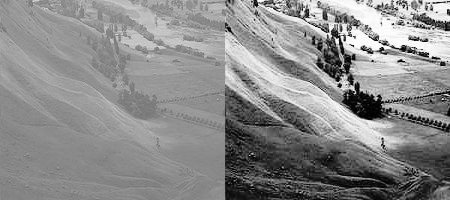

In [ ]:
def splitDataset(ClassName) :

  train_directory = os.path.join(PATH_DIR, 'train')
  val_directory = os.path.join(PATH_DIR, 'val')
  test_directory = os.path.join(PATH_DIR, 'test')

  # Check if the train directory already exists
  if os.path.exists(train_directory):
      return train_directory, val_directory, test_directory

  # Define the percentage split
  train_percentage = 0.7
  val_percentage = 0.15
  test_percentage = 0.15

  # Iterate through each class directory
  for class_dir in os.listdir(PATH_DIR):

      if class_dir not in ClassName :
        continue

      class_path = os.path.join(PATH_DIR, class_dir)

      # Create subdirectories in train, val, and test directories for each class
      train_class_dir = os.path.join(train_directory, class_dir)
      val_class_dir = os.path.join(val_directory, class_dir)
      test_class_dir = os.path.join(test_directory, class_dir)

      os.makedirs(train_class_dir, exist_ok=True)
      os.makedirs(val_class_dir, exist_ok=True)
      os.makedirs(test_class_dir, exist_ok=True)

      # List all image files in the class directory
      images = os.listdir(class_path)
      random.shuffle(images)

      # Calculate the number of images for each split
      num_images = len(images)
      num_train = int(train_percentage * num_images)
      num_val = int(val_percentage * num_images)

      # Split the images into train, val, and test
      train_images = images[:num_train]
      val_images = images[num_train:num_train + num_val]
      test_images = images[num_train + num_val:]

      # Copy the images to their respective directories
      for image in train_images:
          src = os.path.join(class_path, image)
          dst = os.path.join(train_class_dir, image)
          shutil.copy(src, dst)

      for image in val_images:
          src = os.path.join(class_path, image)
          dst = os.path.join(val_class_dir, image)
          shutil.copy(src, dst)

      for image in test_images:
          src = os.path.join(class_path, image)
          dst = os.path.join(test_class_dir, image)
          shutil.copy(src, dst)

  return train_directory, val_directory, test_directory

def optimizationDs(train_dataset, validation_dataset, test_dataset) :

  AUTOTUNE = tf.data.AUTOTUNE

  train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  return train_dataset, validation_dataset, test_dataset

def creationDs(ClassName) :
  path_train, path_val, path_test = splitDataset(ClassName)
  train_ds, val_ds, test_ds = datasetFromDirectory(path_train, path_val, path_test)
  train_dataset, validation_dataset, test_dataset = optimizationDs(train_ds, val_ds, test_ds)

  return train_dataset, validation_dataset, test_dataset

def creationDsAugment(ClassName) :
  path_train, path_val, path_test = splitDataset(ClassName)
  train_ds, val_ds, test_ds = datasetFromDirectory(path_train, path_val, path_test)
  train_ds = augment(train_ds)
  train_dataset, validation_dataset, test_dataset = optimizationDs(train_ds, val_ds, test_ds)

  return train_dataset, validation_dataset, test_dataset

def creationDsFold(ClassName) :
  path_train, path_val, path_test = splitDataset(ClassName)
  train_ds, val_ds, test_ds = datasetFromDirectory(path_train, path_val, path_test)
  inputs, targets = folding(train_ds, val_ds)

  return inputs, targets, test_ds

def creationDsAugmentFold(ClassName) :
  path_train, path_val, path_test = splitDataset(ClassName)
  train_ds, val_ds, test_ds = datasetFromDirectory(path_train, path_val, path_test)
  train_ds = augment(train_ds)
  inputs, targets = folding(train_ds, val_ds)

  return inputs, targets, test_ds

def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

def datasetFromDirectory(path_train, path_val, path_test) :

  train_ds = image_dataset_from_directory(
    path_train,
    seed=SEED,
    shuffle=True,
    color_mode='rgb',
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

  val_ds = image_dataset_from_directory(
    path_val,
    seed=SEED,
    shuffle=True,
    color_mode='rgb',
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

  test_ds = image_dataset_from_directory(
    path_test,
    seed=SEED,
    color_mode='rgb',
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

  return train_ds, val_ds, test_ds

def folding(train_ds, val_ds) :
  train_images = np.concatenate(list(train_ds.map(lambda x, y:x)))
  train_labels = np.concatenate(list(train_ds.map(lambda x, y:y)))

  val_images = np.concatenate(list(val_ds.map(lambda x, y:x)))
  val_labels = np.concatenate(list(val_ds.map(lambda x, y:y)))

  inputs = np.concatenate((train_images, val_images), axis=0)
  targets = np.concatenate((train_labels, val_labels), axis=0)

  return inputs, targets

def augment(train_dataset) :
  # See : https://www.tensorflow.org/tutorials/images/data_augmentation?hl=fr for more informations
  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal', seed=SEED),
  tf.keras.layers.RandomRotation(0.2, seed=SEED, fill_mode='nearest',
                                 interpolation='nearest'),
  #tf.keras.layers.RandomContrast((0.8, 1.2), seed=SEED),
  tf.keras.layers.RandomBrightness((-0.25, 0.25), seed=SEED),
  #tf.keras.layers.RandomZoom(height_factor=(0.0, 0.1), width_factor=(0.0, 0.1),
  #                           fill_mode='reflect', interpolation='nearest',
  #                           seed=SEED)
  ])

  train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

  return train_dataset

In [ ]:
def plotCurve(history) :

  #plot acc
  plt.figure(1, figsize = (15,8))
  plt.subplot(221)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='red', label='test')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  # plot loss
  plt.subplot(222)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='red', label='test')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.show()
  plt.close()

In [ ]:
def plotCurvesKfolding(histories) :

  for i in range(len(histories)) :

    #plot acc
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='red', label='test')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plot loss
    plt.subplot(222)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='red', label='test')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

  plt.show()
  plt.close()

Iterative Process

The training process is an iterative one. During each epoch, the following happens :
- The training dataset is divided into mini-batches (default size determined by the model).
- The model makes predictions on each mini-batch of training data.
- The loss between the predicted values and the actual labels is calculated.
- The model's internal parameters are updated using an optimization algorithm (in this case, 'adam' is used as the optimizer) to minimize the loss.
- The process is repeated for all mini-batches in the training dataset. After one complete pass through the training dataset (an epoch), the model's performance on the validation dataset is evaluated.

Monitoring Training Progress

As the training progresses through multiple epochs, the model gradually improves its performance. You can monitor this progress through the training history, which includes metrics like accuracy and loss. You can use this information to assess how well the model is learning from the data and whether it's overfitting (performing well on the training data but not on new, unseen data).

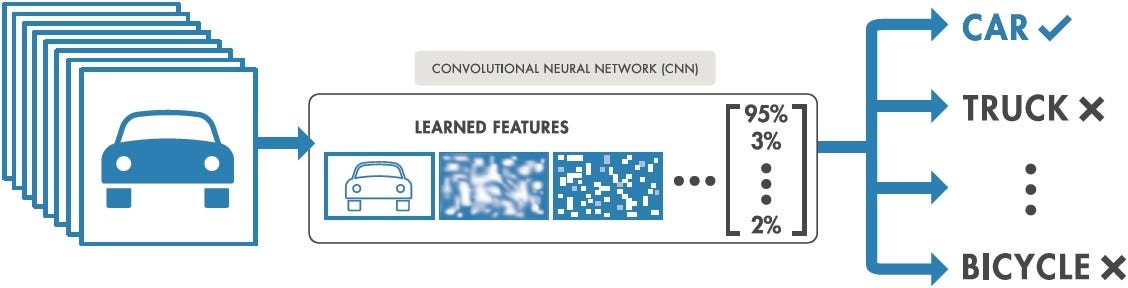

Tensor :

In [ ]:
def trainModelTensor(givenModel, train_ds, val_ds, test_ds) :

    # Record the start time
    start_time = time.time()

    model = givenModel()

    # fit the model
    history = model.fit(train_ds, validation_data=val_ds,
                        verbose=VERBOSE, epochs=100)

    # evaluate du modele
    model.evaluate(test_ds, verbose=VERBOSE)

    #plot acc and loss in function of epochs
    plotCurve(history)

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    print(f"Elapsed time Tensor version : {elapsed_time} seconds")
    return history

Cross-validation is a statistical method used to estimate the skill of machine learning models. It is commonly used in applied machine learning to compare and select a model for a given predictive modeling problem because it is easy to understand, easy to implement, and results in skill estimates that generally have a lower bias than other methods. By partitioning the available data into three sets (train, val and test), we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”

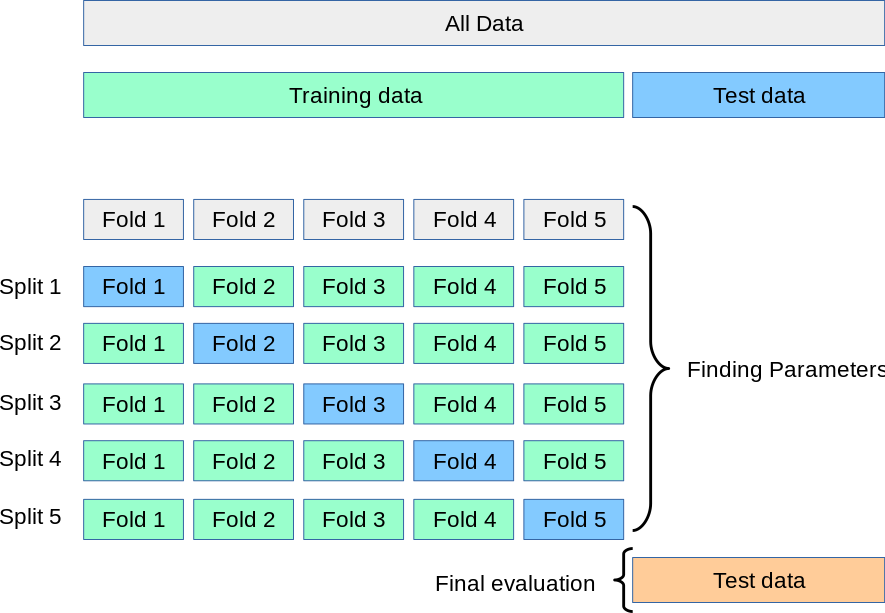

In [ ]:
def trainModelTensorKfoldAugment(givenModel, dataX, dataY, test_ds) :

    scores, histories =[[],[],[],[],[]], list()

    kfold = KFold(N_KFOLDS, shuffle=True, random_state=SEED)

    # parcourir les splits du k-fold
    for fold, (train_ix, eval_ix) in enumerate(kfold.split(dataX), start=1):  # Add enumerate to track the fold number

      print("")
      print(f"############# Fold n°{fold} #############")

      #Redéfinition du modèle
      model = givenModel()

      split_point = int(len(train_ix) * 0.920)

      # Combine eval_ix elements with train_ix for validation data
      X_val = np.concatenate((dataX[train_ix[split_point:]], dataX[eval_ix]), axis=0)
      y_val = np.concatenate((dataY[train_ix[split_point:]], dataY[eval_ix]), axis=0)

      # Selection des données pour training
      X_train, y_train = dataX[train_ix[:split_point]], dataY[train_ix[:split_point]]

      print(f"len(y_train) : {len(y_train)} and len(y_val) : {len(y_val)}")

      datagen.fit(X_train)

      # fit du modele
      history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                          validation_data=(X_val, y_val), epochs=EPOCHS,
                          verbose=VERBOSE, callbacks=CALLBACKS)

      # evaluate du modele
      loss, acc, pre, rec, fscore = model.evaluate(test_ds, verbose=VERBOSE)

      # Create a list of values from the evaluation
      evaluation_values = [loss, acc, pre, rec, fscore]

      # Append the values to the respective scores list
      for i, value in enumerate(evaluation_values):
          scores[i].append(value)

      histories.append(history)

    #plot acc and loss in function of epochs
    plotCurvesKfolding(histories)

    ListMetrics =  ["loss", "accuracy", "precision", "recall", "f1-score"]

    for metric, ListMetricValue in zip(ListMetrics, scores) :

      # Calculate mean and standard deviation
      mean_metric = np.mean(ListMetricValue)
      std_deviation = np.std(ListMetricValue)

      # Calculate the standard error of the mean (SEM)
      sem = std_deviation / np.sqrt(len(ListMetricValue))

      # Set the desired confidence level (e.g., 95%)
      confidence_level = 0.95

      # Calculate the margin of error based on the confidence level
      margin_of_error = stats.t.ppf((1 + confidence_level) / 2, len(ListMetricValue) - 1) * sem

      # Calculate the confidence interval
      lower_bound = mean_metric - margin_of_error
      upper_bound = mean_metric + margin_of_error

      # Print the results
      print(f"Test {metric}: {mean_metric} ± {margin_of_error} (95% CI : [{lower_bound}; {upper_bound}])")

    return histories, scores

Numpy :

In [ ]:
def trainModelNumpy(givenModel, X_train, X_val, X_test, Y_train, Y_val, Y_test) :

    # Record the start time
    start_time = time.time()

    model = givenModel()

    # fit the model
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                        verbose=VERBOSE, epochs=100)
    # evaluate du modele
    model.evaluate(X_test, Y_test, verbose=VERBOSE)

    #plot acc and loss in function of epochs
    plotCurve(history)

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    print(f"Elapsed time Numpy version : {elapsed_time} seconds")
    return history

In [ ]:
def trainModelNumpyKfold(givenModel, dataX, X_test, dataY, Y_test) :

    scores, histories =[[],[],[],[],[]], list()

    kfold = KFold(N_KFOLDS, shuffle=True, random_state=SEED)

    # parcourir les splits du k-fold
    for fold, (train_ix, eval_ix) in enumerate(kfold.split(dataX), start=1):  # Add enumerate to track the fold number

      print(f"############# Fold n°{fold} #############")

      #Redéfinition du modèle
      model = givenModel()

      split_point = int(len(train_ix) * 0.920)

      # Combine eval_ix elements with train_ix for validation data
      X_val = np.concatenate((dataX[train_ix[split_point:]], dataX[eval_ix]), axis=0)
      y_val = np.concatenate((dataY[train_ix[split_point:]], dataY[eval_ix]), axis=0)

      # Selection des données pour training
      X_train, y_train = dataX[train_ix[:split_point]], dataY[train_ix[:split_point]]

      print(f"len(y_train) : {len(y_train)} and len(y_val) : {len(y_val)}")

      # fit du modele
      history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                          validation_data=(X_val, y_val), epochs=EPOCHS,
                          verbose=VERBOSE, callbacks=CALLBACKS)

      # evaluate du modele
      loss, acc, pre, rec = model.evaluate(X_test, Y_test, verbose=VERBOSE)

      # Create a list of values from the evaluation
      evaluation_values = [loss, acc, pre, rec] #, fscore]

      # Append the values to the respective scores list
      for i, value in enumerate(evaluation_values):
          scores[i].append(value)

      histories.append(history)

    #plot acc and loss in function of epochs
    plotCurvesKfolding(histories)

    ListMetrics = ["loss", "accuracy", "precision", "recall"] #, "f1-score"]

    for metric, ListMetricValue in zip(ListMetrics, scores) :

      # Calculate mean and standard deviation
      mean_metric = np.mean(ListMetricValue)
      std_deviation = np.std(ListMetricValue)

      # Calculate the standard error of the mean (SEM)
      sem = std_deviation / np.sqrt(len(ListMetricValue))

      # Set the desired confidence level (e.g., 95%)
      confidence_level = 0.95

      # Calculate the margin of error based on the confidence level
      margin_of_error = stats.t.ppf((1 + confidence_level) / 2, len(ListMetricValue) - 1) * sem

      # Calculate the confidence interval
      lower_bound = mean_metric - margin_of_error
      upper_bound = mean_metric + margin_of_error

      # Print the results
      print(f"Test {metric}: {mean_metric:.3f} ± {margin_of_error:.3f} (95% CI: {lower_bound:.3f}, {upper_bound:.3f})")

    return histories, scores

La Data Augmentation est le processus permettant de générer des données d’entraînement supplémentaires. Elle consiste à appliquer des transformations sur des données existantes pour obtenir de nouvelles données. Cette méthode est couramment utilisée en Machine Learning pour augmenter la taille et la diversité de l’ensemble de données d’entraînement. Au bout cela peut contribuer à améliorer la généralisation du modèle et donc, ses performances.

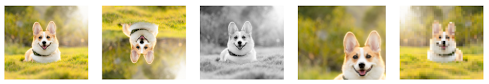

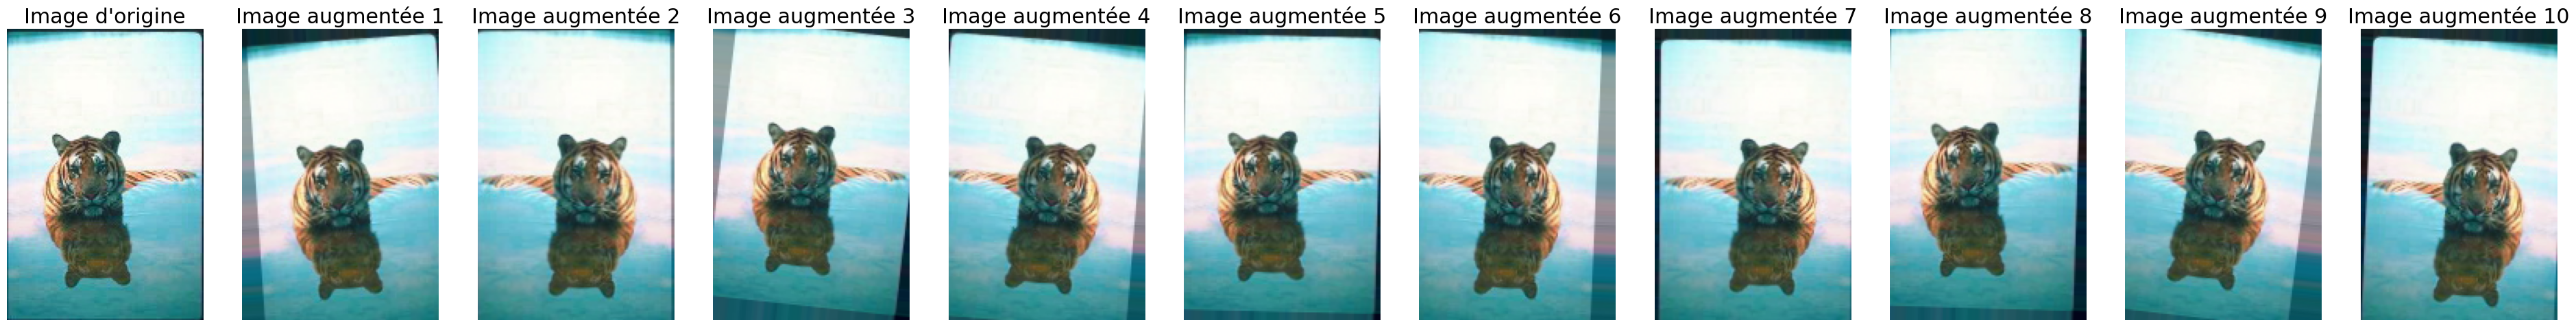

In [ ]:
# Load the image
image_path = 'Tiger-Fox-Elephant/tiger/501.jpg'
original_image = Image.open(image_path)

# Convertir l'image en un tableau numpy
original_image_array = tf.keras.preprocessing.image.img_to_array(original_image)

# Remodeler l'image en (1, hauteur, largeur, canaux)
original_image_array = tf.expand_dims(original_image_array, 0)

# Create an ImageDataGenerator for data augmentation
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    dtype='float'
)

# iterator
aug_iter = datagen.flow(original_image_array, batch_size=1)
num_augmented_images = 10  # Vous pouvez ajuster le nombre d'images augmentées

# Preload augmented images into a list
augmented_images = [original_image]
for _ in range(num_augmented_images):
    augmented_images.append(aug_iter.next()[0].astype('uint8'))

# Plot the original image and augmented images
plt.figure(figsize=(48, 12))
for i in range(num_augmented_images + 1):
    plt.subplot(1, num_augmented_images + 1, i + 1)
    plt.axis('off')
    plt.imshow(augmented_images[i])
    if i == 0:
        plt.title("Image d'origine")
    else:
        plt.title(f"Image augmentée {i}")

plt.savefig(f"Résultats/Data_Augment_Result.png")
plt.show()

In [ ]:
def trainModelNumpyAugment(givenModel, X_train, X_val, X_test, Y_train, Y_val, Y_test) :

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    model = givenModel()

    datagen.fit(X_train)

    # fit du modele
    history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                        validation_data=(X_val, Y_val), epochs=EPOCHS,
                        verbose=VERBOSE) #, callbacks=CALLBACKS)

    # evaluate du modele
    model.evaluate(X_test, Y_test, verbose=VERBOSE)

    #plot acc and loss in function of epochs
    plotCurve(history)

    return history

In [ ]:
def trainModelNumpyKfoldAugment(givenModel, dataX, X_test, dataY, Y_test) :

    scores, histories =[[],[],[],[],[]], list()

    kfold = KFold(N_KFOLDS, shuffle=True, random_state=SEED)

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # parcourir les splits du k-fold
    for fold, (train_ix, eval_ix) in enumerate(kfold.split(dataX), start=1):  # Add enumerate to track the fold number

      print("")
      print(f"############# Fold n°{fold} #############")

      #Redéfinition du modèle
      model = givenModel()

      split_point = int(len(train_ix) * 0.920)

      # Combine eval_ix elements with train_ix for validation data
      X_val = np.concatenate((dataX[train_ix[split_point:]], dataX[eval_ix]), axis=0)
      y_val = np.concatenate((dataY[train_ix[split_point:]], dataY[eval_ix]), axis=0)

      # Selection des données pour training
      X_train, y_train = dataX[train_ix[:split_point]], dataY[train_ix[:split_point]]

      print(f"len(y_train) : {len(y_train)} and len(y_val) : {len(y_val)}")

      datagen.fit(X_train)

      # fit du modele
      history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                          validation_data=(X_val, y_val), epochs=EPOCHS,
                          verbose=VERBOSE, callbacks=CALLBACKS)

      # evaluate du modele
      loss, acc, pre, rec = model.evaluate(X_test, Y_test, verbose=VERBOSE)

      # Create a list of values from the evaluation
      evaluation_values = [loss, acc, pre, rec] #, fscore]

      # Append the values to the respective scores list
      for i, value in enumerate(evaluation_values):
          scores[i].append(value)

      histories.append(history)

    #plot acc and loss in function of epochs
    plotCurvesKfolding(histories)

    ListMetrics =  ["loss", "accuracy", "precision", "recall"] #, "f1-score"]

    for metric, ListMetricValue in zip(ListMetrics, scores) :

      # Calculate mean and standard deviation
      mean_metric = np.mean(ListMetricValue)
      std_deviation = np.std(ListMetricValue)

      # Calculate the standard error of the mean (SEM)
      sem = std_deviation / np.sqrt(len(ListMetricValue))

      # Set the desired confidence level (e.g., 95%)
      confidence_level = 0.95

      # Calculate the margin of error based on the confidence level
      margin_of_error = stats.t.ppf((1 + confidence_level) / 2, len(ListMetricValue) - 1) * sem

      # Calculate the confidence interval
      lower_bound = mean_metric - margin_of_error
      upper_bound = mean_metric + margin_of_error

      # Print the results
      print(f"Test {metric}: {mean_metric} ± {margin_of_error} (95% CI: {lower_bound}, {upper_bound})")

    return histories, scores

# Modèle

In [ ]:
def baseline():
    model = Sequential()

    # ---- Conv / Pool N°1
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # ---- Conv / Pool N°2
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # ---- Conv / Pool N°3
    model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Flattening
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu')) #, kernel_regularizer=L1L2(1e-4)))  # Add L1L2 regularization
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu')) #, kernel_regularizer=L1L2(1e-4)))  # Add L1L2 regularization
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    opt = Adamax(learning_rate=1e-3)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

    return model

# Entrainement des modèles

Tensor (only work with f1-score disable) :

In [ ]:
"""
ClassName = ['tiger', 'Tiger_negative_class']
train_ds, val_ds, test_ds = creationDs(ClassName)
trainModelTensor(baseline, train_ds, val_ds, test_ds)
"""

"\nClassName = ['tiger', 'Tiger_negative_class']\ntrain_ds, val_ds, test_ds = creationDs(ClassName)\ntrainModelTensor(baseline, train_ds, val_ds, test_ds)\n"

Data augment (only work with f1-score disable) :

In [ ]:
"""
ClassName = ['tiger', 'Tiger_negative_class']
train_ds, val_ds, test_ds = creationDsAugment(ClassName)
trainModelTensor(baseline, train_ds, val_ds, test_ds)
"""

"\nClassName = ['tiger', 'Tiger_negative_class']\ntrain_ds, val_ds, test_ds = creationDsAugment(ClassName)\ntrainModelTensor(baseline, train_ds, val_ds, test_ds)\n"

Numpy :

In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
X, y = create_dataset(my_path, my_classes) # gray=False, onehot=False
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=SEED) # .15 pour kfold et .3 pour normal
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=SEED)
print(f"Taille de X_train : {len(X_train)}, Taille de X_val : {len(X_val)}, Taille de X_test : {len(X_test)}")

Les classes :  ['tiger', 'fox', 'elephant']
Nombres de données :  300
Résolution des images :  (128, 128, 3)
Taille de X_train : 210, Taille de X_val : 45, Taille de X_test : 45


In [ ]:
history = trainModelNumpy(baseline, X_train, X_val, X_test, Y_train, Y_val, Y_test)

In [ ]:
history = trainModelNumpyAugment(baseline, X_train, X_val, X_test, Y_train, Y_val, Y_test)

Kfolding :

In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
X, y = create_dataset(my_path, my_classes) # gray=False, onehot=False
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15) # .15 pour kfold et .3 pour normal
print(f"Taille de X_train : {len(X_train)}, Taille de X_test : {len(X_test)}")

Les classes :  ['tiger', 'fox', 'elephant']
Nombres de données :  300
Résolution des images :  (320, 320, 3)
Taille de X_train : 255, Taille de X_test : 45


In [ ]:
histories, scores = trainModelNumpyKfold(baseline, X_train, X_test, Y_train, Y_test)

In [ ]:
histories, scores = trainModelNumpyKfoldAugment(baseline, X_train, X_test, Y_train, Y_test)